In [3]:
from utils import *

In [4]:
# Setup API
import requests
from requests.compat import urljoin
import json
from time import perf_counter_ns

In [5]:
api_host = "http://localhost"
boxes_endpoint = "boxes/"

boxes_url = urljoin(api_host, boxes_endpoint)
response = requests.get(url=boxes_url)
response.json()[:1]

[{'x_min': 75.0,
  'x_max': 83.0,
  'y_min': 36.0,
  'y_max': 65.0,
  'z_min': 48.0,
  'z_max': 70.0,
  'id': '79147250-1865-42f0-b28c-82d6131c5052'}]

In [6]:

# for box in boxes:
#     data = {
#         "x_min": min(box[0]),
#         "x_max": max(box[0]),
#         "y_min": min(box[1]),
#         "y_max": max(box[1]),
#         "z_min": min(box[2]),
#         "z_max": max(box[2]),
#     }
#     for key, value in data.items():
#         data[key] = int(value)
#     print(data)
#     response = requests.post(urljoin(api_host, boxes_endpoint), json=data)
#     assert response.status_code == 200, response.json()

In [7]:
def show_3d_boxes(boxes, lines_args):
    fig = go.Figure()

    for box in boxes:
        add_mesh_3d(fig, box)
        
    for line_args in lines_args:
        add_line_3d(fig, **line_args)

    fig.update_layout(
        scene = {
            "xaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
            "yaxis": {
                "nticks": 4, 
                "range": [0, 1000],
            },
            "zaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
            "aspectmode": "cube"
        },
        width=700,
        margin=dict(r=20, l=10, b=10, t=10),
    )

    fig.show()
    
    return fig

In [8]:
response = requests.get(f"{boxes_url}?x=20&y=500")

In [9]:
from typing import Dict, Any

def convert_box_json_to_nparray(box_obj: Dict[str, Any]):
    del box_obj["id"]
    box_array = get_box_points_array(
        **box_obj
    )
    return box_array

# convert_box_json_to_nparray(response.json()[0])

In [10]:
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
response_boxes[:2]

[array([[  9.,   9.,  48.,  48.,   9.,   9.,  48.,  48.],
        [504., 545., 545., 504., 504., 545., 545., 504.],
        [512., 512., 512., 512., 597., 597., 597., 597.]])]

In [26]:
def build_query_string(**kwargs):
    query_params = []
    for key, val in kwargs.items():
        if val:
            query_params.append(f"{key}={val}")
    return "&".join(query_params)


def get_query_param_lines(x: int, y: int, z: int, axis_min: int, axis_max: int):
    x_none = x is None
    y_none = y is None
    z_none = z is None
    query_param_lines = []
    if x_none:
        x = 0
    if y_none:
        y = 0
    if z_none:
        z = 0
    
    if not x_none:
        query_param_lines.append(
            {
                "coordinates":np.array([[x, x], [axis_min, axis_max], [z, z]]),
                "name": "x"
            }
        )
    if not y_none:
        query_param_lines.append(
            {
                "coordinates": np.array([[x, x], [y, y], [axis_min, axis_max]]),
                "name": "y",
            }
        )
    if not z_none:
        query_param_lines.append(
            {
                "coordinates": np.array([[axis_min, axis_max], [y, y], [z, z]]),
                "name": "z"
            }
        )
    
    return query_param_lines

In [34]:
import random

def get_random_distribution_from_list(objects: List[Any], size: int):
    """
    Return a random subset of objects from list
    """
    objects_indexes = list(range(len(objects)))
    return_list = []
    i = 0
    while i < size and objects_indexes:
        random_index = random.randrange(len(objects_indexes))
        return_list.append(objects[objects_indexes[random_index]])
        del objects_indexes[random_index]
        i += 1
    return return_list


some_range = list(range(10))

get_random_distribution_from_list(some_range, 100)
    

[1, 3, 5, 7, 8, 4, 6, 0, 9, 2]

Query Parameters: 
Response Time: 167ms
2040 Boxes in Response
Showing 100 Boxes


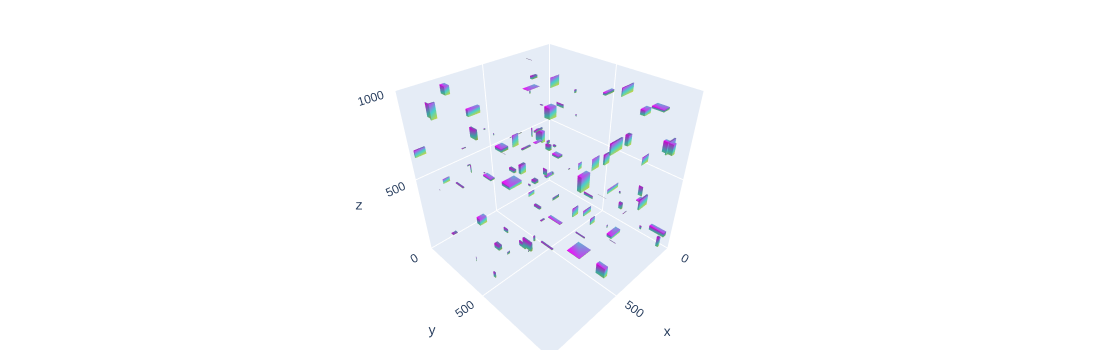

In [36]:
# Config and Params
num_boxes_show = 100
query_args = {
    "x": None,
    "y": None,
    "z": None
}
query_params = build_query_string(**query_args)
print(f"Query Parameters: {query_params}")

# Request/Response
start = perf_counter_ns()
response = requests.get(f"{boxes_url}?{query_params}")
end = perf_counter_ns()

# Display
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
response_boxes_show = get_random_distribution_from_list(response_boxes, size=num_boxes_show)
query_param_lines = get_query_param_lines(axis_min=0, axis_max=1000, **query_args)
# print(query_param_lines)
print(f"Response Time: {format_perf_time(end - start)}")
print(f"{len(response_boxes)} Boxes in Response")
print(f"Showing {len(response_boxes_show)} Boxes")
data = show_3d_boxes(response_boxes_show, query_param_lines)

In [37]:
import chart_studio.plotly as py
py.plot(data, filename='space_partitioning_01', auto_open=True)

'https://plotly.com/~richard.autry/5/'